# CVD(심혈관질환) 로지스틱 회귀를 통한 분석
* 문제의 컨텍스트 및 관련성 이해
* 데이터 분석 및 모델 해석에 도움이 될 수 있는 도메인 지식 추출
* 전문가의 지식을 데이터셋의 피처와 연관 짓기

CVD는 전 세계적으로 주요 사망 원인이며 연간 1,800만 명이 이 질병으로 사망한다.  
뇌졸증은 CVD의 중요 원인이다. 아래는 예빵 가능 요인 및 불가능한 것으로 구분되어 있다.  
### 예방 가능
* 잘못된 식습관
* 흡연/음주
* 비만
* 신체 활동 부족
* 수면 부족

### 예방 불가능
* 유전적 요인
* 노령
* 남성


In [1]:
import math
import machine_learning_datasets as mldatasets
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

2024-01-14 21:44:24.013644: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-14 21:44:24.013659: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/studio/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [26]:
cvd_df = mldatasets.load("cardiovascular-disease")

https://raw.githubusercontent.com/caravanuden/cardio/master/cardio_train.csv downloaded to /home/studio/바탕화면/ml/LogisticRegression/data/cardio_train.csv
1 dataset files found in /home/studio/바탕화면/ml/LogisticRegression/data folder
parsing /home/studio/바탕화면/ml/LogisticRegression/data/cardio_train.csv


데이터의 구성을 보면 객관적 피처/주관적 피처/검사 피처 로 구분되어 질 수 있음을 볼 수 있다.

In [3]:
cvd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


날수로 되어있는 나이를 연수로 바꾸어준다. 일종의 피처 엔지니어링

In [4]:
cvd_df['age'] =  cvd_df['age'] / 365.24

ap_hi와 ap_lo의 min/max는 이상치를 가지고 있다. 그렇기 때문에 이상치를 제거한다.

In [5]:
cvd_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,70000.0,53.304309,6.755152,29.564122,48.36272,53.945351,58.391742,64.924433
gender,70000.0,1.349571,0.476838,1.000000,1.00000,1.000000,2.000000,2.000000
height,70000.0,164.359229,8.210126,55.000000,159.00000,165.000000,170.000000,250.000000
weight,70000.0,74.205690,14.395757,10.000000,65.00000,72.000000,82.000000,200.000000
ap_hi,70000.0,128.817286,154.011419,-150.000000,120.00000,120.000000,140.000000,16020.000000
ap_lo,70000.0,96.630414,188.472530,-70.000000,80.00000,80.000000,90.000000,11000.000000
cholesterol,70000.0,1.366871,0.680250,1.000000,1.00000,1.000000,2.000000,3.000000
gluc,70000.0,1.226457,0.572270,1.000000,1.00000,1.000000,1.000000,3.000000
smoke,70000.0,0.088129,0.283484,0.000000,0.00000,0.000000,0.000000,1.000000
alco,70000.0,0.053771,0.225568,0.000000,0.00000,0.000000,0.000000,1.000000


In [6]:
cvd_df = cvd_df[(cvd_df['ap_lo'] <= 370) & (cvd_df['ap_lo'] > 0)].reset_index(drop=True)
cvd_df = cvd_df[(cvd_df['ap_hi'] <= 370) & (cvd_df['ap_hi'] > 0)].reset_index(drop=True)
cvd_df = cvd_df[cvd_df['ap_hi'] >= cvd_df['ap_lo']].reset_index(drop=True)

로지스틱 회귀 모델에 넣기 위해 목표 피처(y)를 제외한 나머지 피처를 남겨둔다.

In [7]:
y = cvd_df['cardio']
X = cvd_df.drop(['cardio'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=9)

In [8]:
log_model = sm.Logit(y_train, sm.add_constant(X_train))
log_result = log_model.fit()
print(log_result.summary2())

Optimization terminated successfully.
         Current function value: 0.561557
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.190     
Dependent Variable: cardio           AIC:              65618.3485
Date:               2024-01-14 21:44 BIC:              65726.0502
No. Observations:   58404            Log-Likelihood:   -32797.   
Df Model:           11               LL-Null:          -40481.   
Df Residuals:       58392            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
-----------------------------------------------------------------
const         -11.1730   0.2504 -44.6182 0.0000 -11.6638 -10.6822
age             0.0510   0.0015  34.7971 0.0000   0.0482   0.0539


/home/studio/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


직관적으로 해석하기 위해서 오즈를 구한다. 이 결과 콜레스테롤이 1증가할 때 cvd의 오즈는 1.64 증가하는 것을 알 수 있다.

In [9]:
np.exp(log_result.params).sort_values(ascending=False)

cholesterol    1.637374
ap_hi          1.057676
age            1.052357
weight         1.011129
ap_lo          1.010573
height         0.996389
gender         0.977519
gluc           0.890913
smoke          0.877576
alco           0.814627
active         0.806471
const          0.000014
dtype: float64

In [10]:
np.std(X_train, 0)

age             6.757537
gender          0.476697
height          8.186987
weight         14.335173
ap_hi          16.703572
ap_lo           9.547583
cholesterol     0.678878
gluc            0.571231
smoke           0.283629
alco            0.225483
active          0.397215
dtype: float64

표춘편차*계수 => 표춘편차를 통합하면 피처 간의 분산 차이 설명 가능  
이와 같은 방법론을 모델 종속적인(model-specific)/글로벌 모듈러 해석 방법론(global modular interpretation)

In [11]:
coefs = log_result.params.drop(labels=['const','gender'])
stdv = np.std(X_train, 0).drop(labels='gender')
abs(coefs * stdv).sort_values(ascending=False)

ap_hi          0.936632
age            0.344855
cholesterol    0.334750
weight         0.158651
ap_lo          0.100419
active         0.085436
gluc           0.065982
alco           0.046230
smoke          0.037040
height         0.029620
dtype: float64

의사 결정 경계 확인 및 세테리스 파리부스 가정 확인  


In [12]:
y_pred = log_result.predict(sm.add_constant(X_test)).to_numpy()
print(y_pred)

[0.40629892 0.17003609 0.13405939 ... 0.95575283 0.94095239 0.91455717]


In [13]:

print(y_pred[2872])

0.5746680418975681


In [14]:
print(X_test.iloc[2872])

age             60.521849
gender           1.000000
height         158.000000
weight          62.000000
ap_hi          130.000000
ap_lo           80.000000
cholesterol      1.000000
gluc             1.000000
smoke            0.000000
alco             0.000000
active           1.000000
Name: 46965, dtype: float64


In [15]:
filler_feature_values = {0: 1, 1: 30, 2: 1, 3: 165, 4: 57, 5: 110, 
                       6: 70, 7: 1, 8: 1, 9: 0, 10:0, 11:1
                    }

In [16]:
filler_feature_ranges = {0: 1, 1: 35, 2: 2, 3: 110, 4: 150, 5: 140, 
                       6: 70, 7: 3, 8: 3, 9: 2, 10:2, 11:2
                      }

In [17]:
X_highlight = np.reshape(np.concatenate(([1],X_test.iloc[2872].to_numpy())), (1, 12))
print(X_highlight)

[[  1.          60.52184865   1.         158.          62.
  130.          80.           1.           1.           0.
    0.           1.        ]]


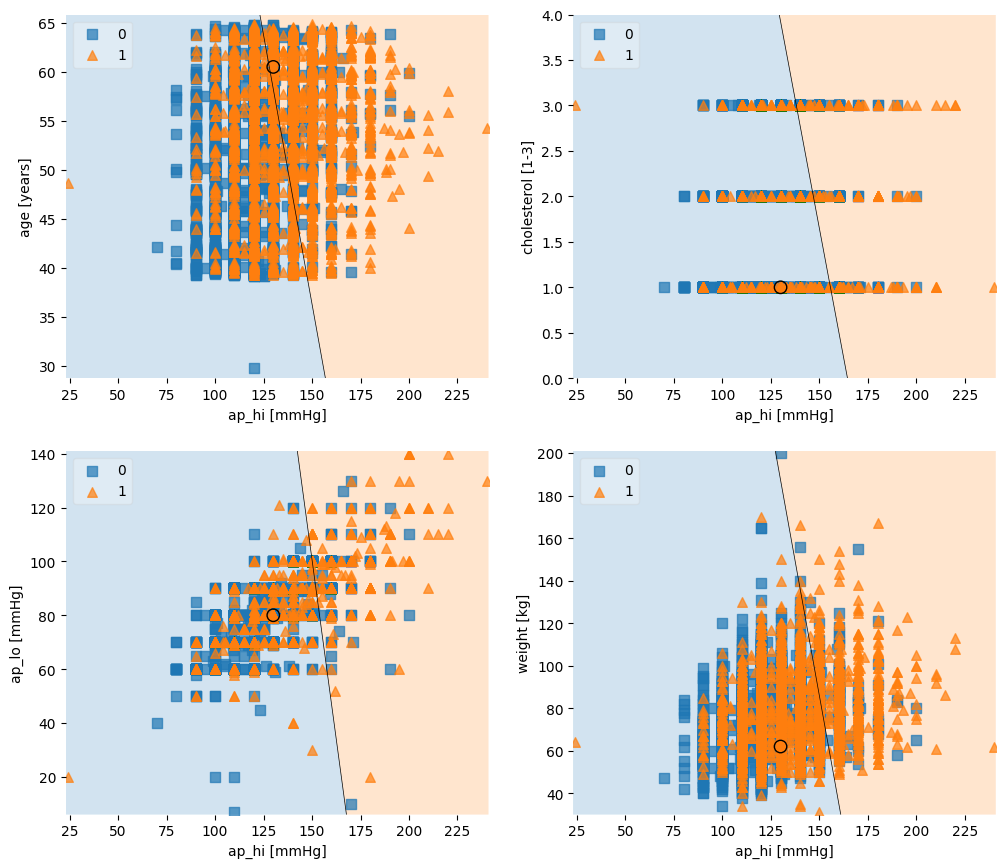

In [18]:
# plt.rcParams.update({'font.size': 14})
fig, axarr = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=False)
mldatasets.create_decision_plot(X_test, y_test, log_result, [5, 1], ['ap_hi [mmHg]', 'age [years]'], 
                     X_highlight, filler_feature_values, filler_feature_ranges, ax=axarr.flat[0])
mldatasets.create_decision_plot(X_test, y_test, log_result, [5, 7], ['ap_hi [mmHg]', 'cholesterol [1-3]'], 
                     X_highlight, filler_feature_values, filler_feature_ranges, ax=axarr.flat[1])
mldatasets.create_decision_plot(X_test, y_test, log_result, [5, 6], ['ap_hi [mmHg]', 'ap_lo [mmHg]'], 
                     X_highlight, filler_feature_values, filler_feature_ranges, ax=axarr.flat[2])
mldatasets.create_decision_plot(X_test, y_test, log_result, [5, 4], ['ap_hi [mmHg]', 'weight [kg]'], 
                     X_highlight, filler_feature_values, filler_feature_ranges, ax=axarr.flat[3])
plt.subplots_adjust(top = 1, bottom=0, hspace=0.2, wspace=0.2)
plt.show()

ap_hi와 weight의 패턴이 없는 이유에 대하여 설명  
몸무게와 키의 관계는 단순히 보기에는 선형적인 관계를 가지고 있지 않다.  
이러한 비선형 관계를 BMI 지수를 활용하면 선형 관계로 변환 시킬 수 있으며 해당 피처를 추가로 넣어 결정 경계 확인을 진행한다.

/home/studio/anaconda3/envs/ml/lib/python3.7/site-packages/mlxtend/plotting/decision_regions.py:315: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels, **contour_kwargs)


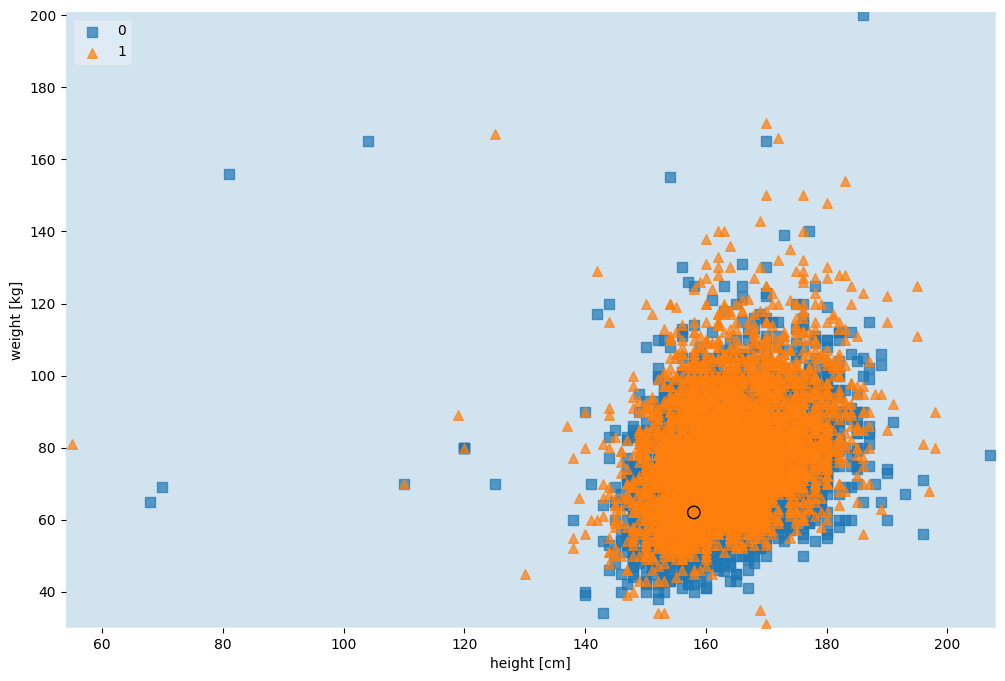

In [19]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
mldatasets.create_decision_plot(X_test, y_test, log_result, [3, 4], ['height [cm]', 'weight [kg]'], 
                     X_highlight, filler_feature_values, filler_feature_ranges, ax=ax)
plt.show()

In [20]:
X2 = cvd_df.drop(['cardio'], axis=1).copy()
X2["bmi"] = X2["weight"] / (X2["height"]/100)**2

이제 새로운 선형 관계가 생성 되었다.

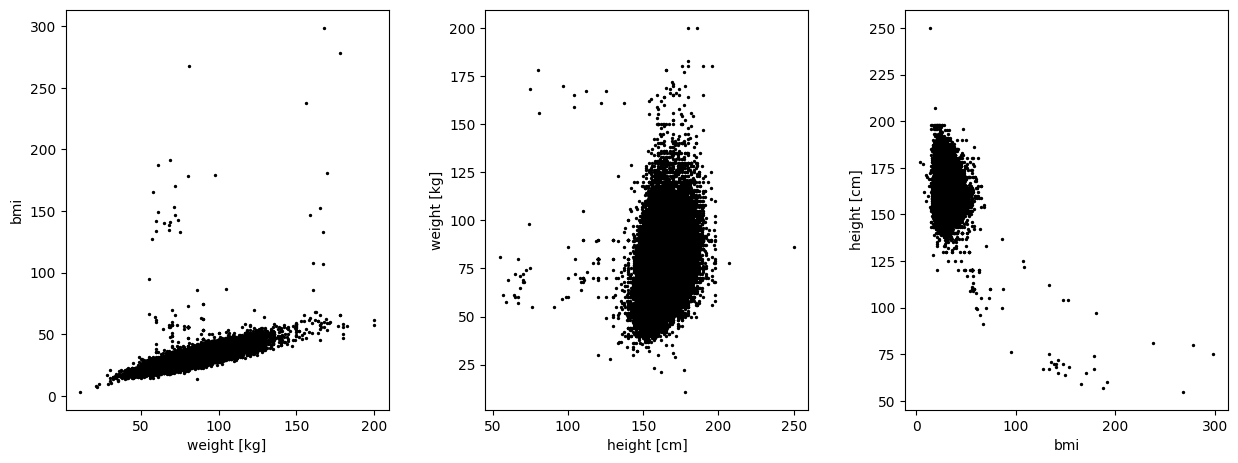

In [21]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
plt.rcParams.update({'font.size': 14})
axs[0].scatter(X2["weight"], X2["bmi"], color='black', s=2)
axs[0].set_xlabel('weight [kg]')
axs[0].set_ylabel('bmi')
axs[1].scatter(X2["height"], X2["weight"], color='black', s=2)
axs[1].set_xlabel('height [cm]')
axs[1].set_ylabel('weight [kg]')
axs[2].scatter(X2["bmi"], X2["height"], color='black', s=2)
axs[2].set_xlabel('bmi')
axs[2].set_ylabel('height [cm]')
plt.subplots_adjust(top = 1, bottom=0, hspace=0.2, wspace=0.3)
plt.show()

In [22]:
X2 = X2.drop(['weight','height'], axis=1)
X2_train, X2_test, _, _ = train_test_split(X2, y, test_size=0.15, random_state=9)

In [23]:
log_model2 = sm.Logit(y_train, sm.add_constant(X2_train))
log_result2 = log_model2.fit()

Optimization terminated successfully.
         Current function value: 0.562104
         Iterations 6


이제는 bmi와 ap_hi를 통해 몸무게+키와 혈압에 대한 패턴을 확인할 수 있다.

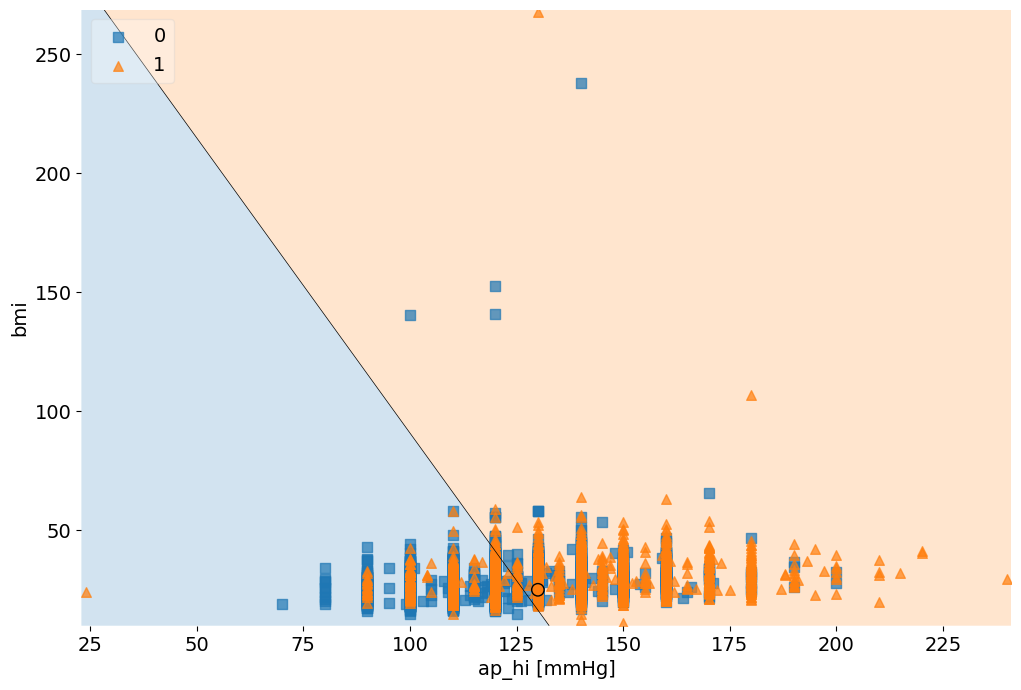

In [24]:
filler_feature_values2 = {0: 1, 1: 60, 2: 1, 3: 110, 
                       4: 70, 5: 1, 6: 1, 7: 0, 8:0, 9:1, 10:20
                    }
filler_feature_ranges2 = {0: 1, 1: 35, 2: 2, 3: 140, 
                       4: 70, 5: 3, 6: 3, 7: 2, 8:2, 9:2, 10:250
                      }
X2_highlight = np.reshape(np.concatenate(([1],X2_test.iloc[2872].to_numpy())), (1, 11))
fig, ax = plt.subplots(1,1, figsize=(12,8))
mldatasets.create_decision_plot(X2_test, y_test, log_result2, [3, 10], ['ap_hi [mmHg]', 'bmi'], 
                     X2_highlight, filler_feature_values2, filler_feature_ranges2, ax=ax)
plt.show()